In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [2]:
def init_matplotlib():
    """Just some Matplotlib settings."""
    plt.style.use('seaborn')
    #matplotlib.rcParams["figure.figsize"] = (15, 6)
    #matplotlib.rcParams["figure.dpi"] = 300
    #matplotlib.rcParams["font.size"] = 32
    #matplotlib.rcParams["axes.titlesize"] = 'x-large'
init_matplotlib()

In [3]:
def custom_read_csv(filename):
    df = pd.read_csv(filename)
    df['date'] = pd.to_datetime(df['date'])
    return df.set_index('date')

In [4]:
# note that all prices are released on Monday, dayofweek = 0
national_price = custom_read_csv('national.csv').dropna()
state_price = custom_read_csv('state.csv').dropna()
state_price = state_price.drop('Unnamed: 10', axis=1).dropna()
city_price = custom_read_csv('city.csv').dropna()
price = pd.concat([national_price, state_price, city_price], axis=1)

In [5]:
returns = (price - price.shift(1)) / price.shift(1)

In [6]:
# the predictors are relaesed on Friday, add 3 days to align
spot = custom_read_csv('spot.csv').drop('Unnamed: 3', axis=1).dropna()
gasspot = custom_read_csv('gasspot.csv').drop('Unnamed: 3', axis=1).dropna()
supply = custom_read_csv('productsupplied.csv').dropna()
stocks = custom_read_csv('stocks.csv').dropna()
predictors = pd.concat([spot, gasspot, supply, stocks], axis=1)
predictors.index = predictors.index + pd.DateOffset(days=3)

In [7]:
predictors = (predictors - predictors.shift(1)) / predictors.shift(1)

In [8]:
yearly_return = returns.national.groupby(price.index.year).median()

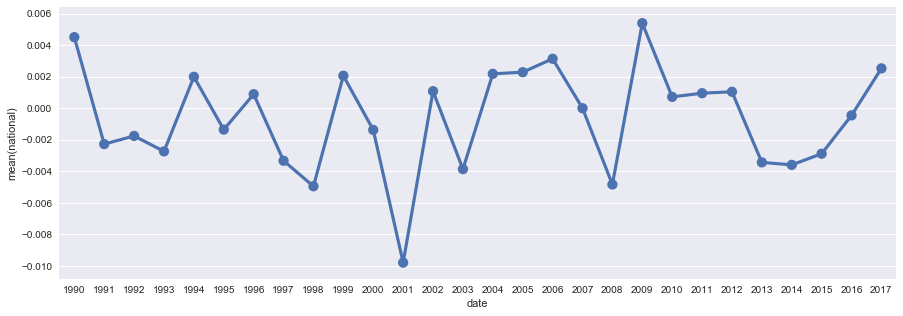

In [9]:
fig, ax = plt.subplots(figsize=(15,5))
sns.pointplot(yearly_return.index.astype(int), yearly_return, ax=ax)
plt.show()

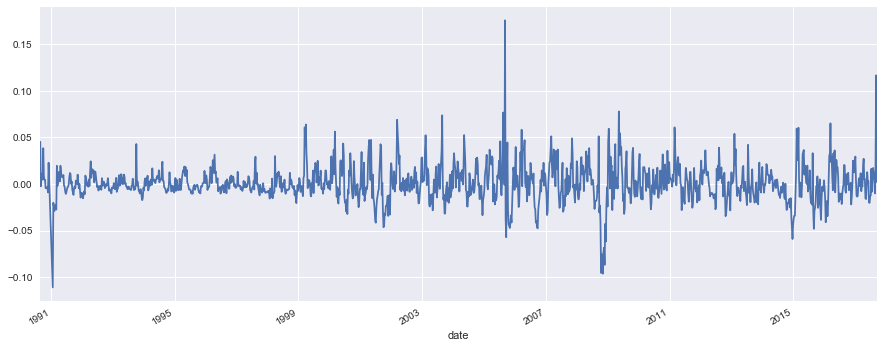

In [28]:
returns.national.plot(figsize=(15,6))

In [10]:
correls = pd.concat([returns.national, predictors], axis=1).rolling(window=250).corr()
correls.columns.names = ['series2']
correls.index.names = ['date', 'series1']
correls = correls.loc[(slice(None), 'national'),:].dropna().drop('national', axis=1)

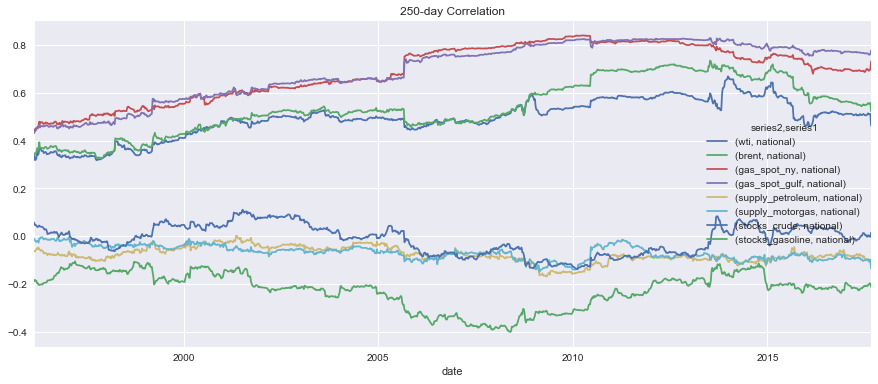

In [11]:
correls.unstack().dropna().plot(figsize=(15,6), title='250-day Correlation')
plt.show()

In [12]:
def regress(predictor, response, start, end, halflife, returnr2=False):
    '''
        helper function to run regression
        predictor: dataframe of predictors
        response: series of response
        start: start date
        end: end date
        halflife: halflife to weight regression exponentially
    '''
    y = response[start:end].values
    X = predictor[start:end].values
    
    assert X.shape[0] == y.shape[0], "predictor and response are not the same length"
    
    w = np.ones(y.shape)
    decay = 2.0 ** (-1.0/halflife)
    for i in range(len(w)-2, -1, -1):
        w[i] = w[i+1] * decay
    
    reg = LinearRegression(normalize=True)
    reg.fit(X, y, sample_weight=w)
    if returnr2:
        return (reg, reg.score(X,y))
    return reg

In [13]:
# Rolling regression

window = 52 * 5
halflife = 52 * 5
dates = returns.national['1992-01-01':'2010-12-31'].index

coef_arr = np.ones((len(dates), len(predictors.columns))) * np.nan
r2_arr = np.ones(len(dates)) * np.nan
reg = np.empty(len(dates), dtype=object)
for t in range(window, len(dates)):
    reg[t], r2_arr[t] = regress(predictors, returns.national, dates[t-window], dates[t], halflife, returnr2=True)
    coef_arr[t] = reg[t].coef_
r2 = pd.Series(r2_arr, index=dates, name='r2').dropna()
coef = pd.DataFrame(coef_arr, index=dates, columns=predictors.columns).dropna()
regobj = pd.Series(reg[window:], index=dates[window:], name='regress_object')

/Users/ChingYunH/anaconda/lib/python2.7/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [14]:
df = pd.concat([pd.Series(dates[window:], index=regobj.index, name='date'), 
                regobj], axis=1).shift(1).dropna()
prediction = df.apply(lambda x: x.regress_object.predict(predictors.loc[x.date].values.reshape(1,-1)), axis=1)['date']
prediction = prediction.rename('predicted').rename_axis('date')

In [15]:
corr_prediction_actual = pd.concat([returns.national, prediction], axis=1).rolling(
    window=52 * 2).corr().dropna().loc[(slice(None), 'national'),'predicted']

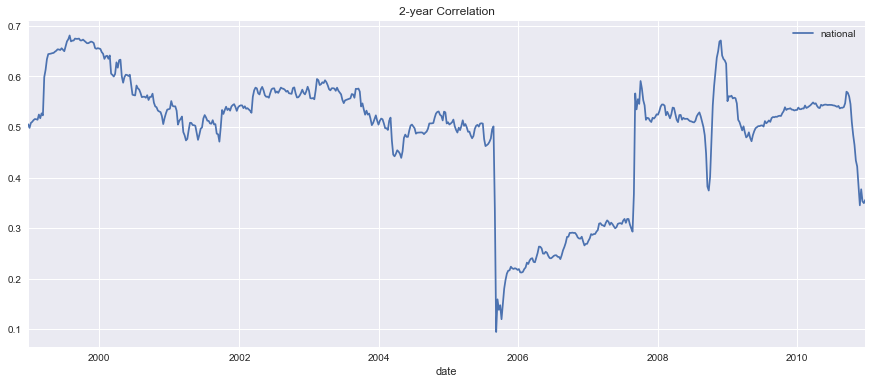

In [16]:
corr_prediction_actual.unstack().dropna().plot(figsize=(15,6), title='2-year Correlation')
plt.show()

In [17]:
corr_prediction_actual.describe()

count    627.000000
mean       0.494434
std        0.118460
min        0.094382
25%        0.486760
50%        0.523120
75%        0.560024
max        0.681042
Name: predicted, dtype: float64

In [18]:
# Rolling regression

window = 52 * 2
halflife = 52
dates = returns.national['1992-01-01':'2010-12-31'].index

coef_arr = np.ones((len(dates), len(predictors.columns))) * np.nan
r2_arr = np.ones(len(dates)) * np.nan
reg = np.empty(len(dates), dtype=object)
for t in range(window, len(dates)):
    reg[t], r2_arr[t] = regress(predictors, returns.national, dates[t-window], dates[t], halflife, returnr2=True)
    coef_arr[t] = reg[t].coef_
r2 = pd.Series(r2_arr, index=dates, name='r2').dropna()
coef = pd.DataFrame(coef_arr, index=dates, columns=predictors.columns).dropna()
regobj = pd.Series(reg[window:], index=dates[window:], name='regress_object')

In [19]:
df = pd.concat([pd.Series(dates[window:], index=regobj.index, name='date'), 
                regobj], axis=1).shift(1).dropna()
prediction = df.apply(lambda x: x.regress_object.predict(predictors.loc[x.date].values.reshape(1,-1)), axis=1)['date']
prediction = prediction.rename('predicted').rename_axis('date')

In [20]:
corr_prediction_actual = pd.concat([returns.national, prediction], axis=1).rolling(
    window=52 * 2).corr().dropna().loc[(slice(None), 'national'),'predicted']

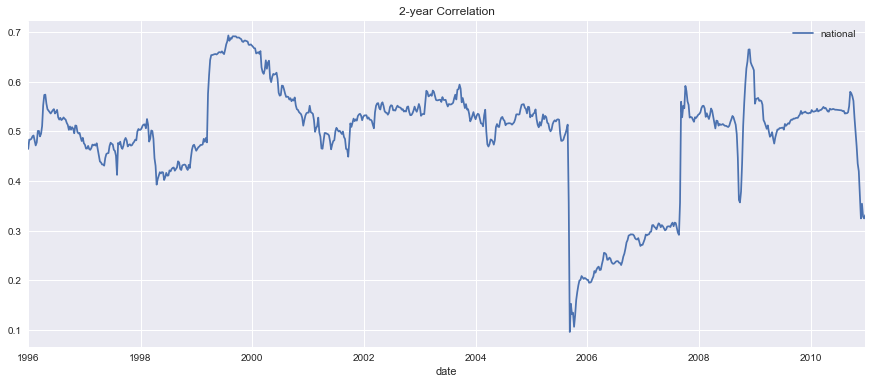

In [21]:
corr_prediction_actual.unstack().dropna().plot(figsize=(15,6), title='2-year Correlation')
plt.show()

In [22]:
corr_prediction_actual.describe()

count    783.000000
mean       0.491303
std        0.111102
min        0.095628
25%        0.471150
50%        0.520292
75%        0.544990
max        0.693009
Name: predicted, dtype: float64

In [23]:
acf_1week = pd.concat([returns.national, returns.national.shift(1).rename('lagged')], axis=1).rolling(
    window=2*52).corr().dropna().loc[(slice(None), 'national'),'lagged']

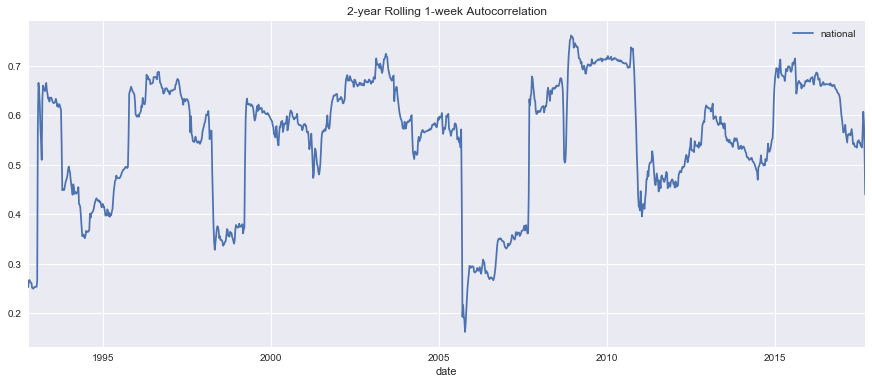

In [24]:
acf_1week.unstack().dropna().plot(figsize=(15,6), title='2-year Rolling 1-week Autocorrelation')
plt.show()

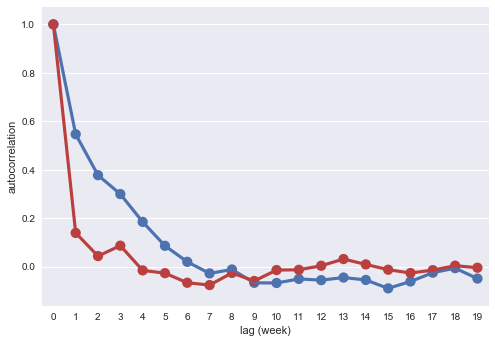

In [36]:
ax = sns.pointplot(np.arange(20), map(lambda x: returns.national.autocorr(x), np.arange(20)),
                   label='Autocorrelation of National Gas Price Return')

ax = sns.pointplot(np.arange(20), map(lambda x: predictors.gas_spot_ny.autocorr(x), np.arange(20)),
                   label='Autocorrelation of Gas Spot (NY) Return',
                   color="#bb3f3f")
ax.set(xlabel='lag (week)', ylabel='autocorrelation')
plt.show()

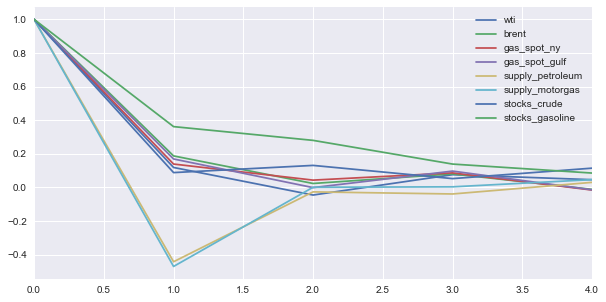

In [37]:
df = pd.concat([pd.Series(map(lambda x: predictors[col].autocorr(x), np.arange(20)), 
           index=np.arange(20), name='acf') for col in predictors.columns], axis=1)
df.columns = predictors.columns
df[:5].plot(figsize=(10, 5))
plt.show()